# Построение собственных сетей CNN + FFN

### Гриневская Катя, БКЛ182

In [1]:
! pip install spacy --upgrade

     |████████████████████████████████| 6.0 MB 5.4 MB/s 
     |████████████████████████████████| 10.1 MB 35.4 MB/s 
     |████████████████████████████████| 628 kB 35.8 MB/s 
     |████████████████████████████████| 181 kB 48.5 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 451 kB 45.6 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [2]:
! python -m spacy download ru_core_news_md

     |████████████████████████████████| 43.0 MB 1.7 MB/s 
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 8.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import random
import spacy
import re

In [4]:
! wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
! wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

--2021-11-26 17:11:23--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-26 17:11:23--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a9ea3bd3e716f5c3e9282c2d1.dl.dropboxusercontent.com/cd/0/inline/BavS0kyDGbctQcvN0n_4VLTGLHogYw4wErIHWyWMZgOyqtzMLdlhnkWnwYARIkgNfyFCkZSqiEfVUEAwJHEFmYZdkcODw9zDxZXR32Pb5hJZIcX0bwzIzA7IUbSSBKBD13pzJGS48b-Qw_j-FtBa6ryS/file# [following]
--2021-11-26 17:11:23--  https://uc2a9ea3bd3e716f5c3e9282c2d1.dl.dropboxusercontent.com/cd/0/inline/BavS0kyDGbctQcvN0n_4VLTGLHogYw4wErIHWyWMZgOyqtzMLdlhnkWnwYARIkgNfyFCkZSqiEfVUEAwJHEFmYZdk

In [5]:
nlp = spacy.load('ru_core_news_md')

In [6]:
pos_df = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0, 1,'name','text','tone',5,6,7,8,9,10,11])
neg_df = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,'name','text','tone',5,6,7,8,9,10,11])

In [7]:
pos_df.head()

,0,1,name,text,tone,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [8]:
neg_df.head()

,0,1,name,text,tone,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [9]:
neg_df['tone'] = 0
neg_df.head()

,0,1,name,text,tone,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,0,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",0,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",0,0,0,0,35,17,34,0


In [10]:
all_df = pos_df.append(neg_df)

In [11]:
len(all_df)

226834

In [12]:
all_df = shuffle(all_df[['text', 'tone']])[:100000]

In [13]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [14]:
all_df['clean_text'] = all_df['text'].apply(lambda x: preprocess_text(x))
all_df.head()

,text,tone,clean_text
15177,@Alexandro_Owl расчитывал прийти до девяти.,0,USER расчитывал прийти до девяти
8446,Типичные признаки твиттерского: а) в детстве ...,1,типичные признаки твиттерского а в детстве чит...
88972,"Моя маленький Беслан,буду очень скучать по тебе((",0,моя маленький беслан буду очень скучать по тебе
54361,RT @eternalinscrip: С Крисс:* http://t.co/6Wpv...,1,rt USER с крисс URL
16682,"RT @lavogemequsy: ""...Твоё лицо стало бледное,...",1,rt USER твое лицо стало бледное как задница не...


In [15]:
train_sentences, val_sentences = train_test_split(all_df, test_size=0.2)

In [16]:
vocab = Counter()

for text in all_df['clean_text']:
    vocab.update(text.split())

In [17]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

In [18]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [19]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [20]:
train_dataset = MyDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

## CNN на уровне слов

In [21]:
from gensim.models import FastText

In [22]:
ft = FastText(all_df['clean_text'].tolist(), size=100, window=5, min_count=1)

In [23]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # словам, которых нет в модели, присваиваем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [24]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [25]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embed_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embed_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_cat = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.h2out = nn.Linear(180, 1)
        self.act2 = nn.Sigmoid() 
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        # batch_size x embedding_dim x seq_len
        feat_bigr = self.act1(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feat_trigr = self.act1(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*
        concat = torch.cat((feat_bigr, feat_trigr), 1)
        bigrams = self.pooling(self.act1(self.bigrams_over_cat(concat)))
        pooling = bigrams.max(2)[0] 
        # batch _size x (filter_count2 + filter_count3)
        proba = self.h2out(pooling) 
        proba = self.act2(proba) 
        return proba

In [97]:
def train(model, train_l, val_l, optimizer, criterion, device, metric, n_epochs):
    set_seed(42)
    losses = []
    val_losses = []
    val_losses_epoch = []
    val_f1s = []
    val_f1_epoch = []
    print('Training...')
    for n_epoch in range(n_epochs):
        try:
            progress_bar = tqdm(total=len(train_l.dataset), desc='Epoch {}'.format(n_epoch + 1))
            model.train() # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов
            for x, y in train_l:
                optimizer.zero_grad() # обнуляем градиенты
                y_pred = model(x) # прогоняем данные через модель
                loss = criterion(y_pred, y) # считаем значение функции потерь
                loss.backward()  # считаем градиенты  
                optimizer.step() # обновляем веса 
                losses.append(loss.item()) # сохраняем значение функции потерь
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))
                progress_bar.update(x.shape[0])
            progress_bar.close()
            val_loss, val_metric = evaluate(val_l, model, criterion, metric, device)
            val_losses.extend(val_loss)
            val_f1s.extend(val_metric)
        except KeyboardInterrupt:
            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_f1s, val_f1_epoch

In [67]:
def evaluate(dataloader, model, criterion, metric, device=DEVICE):
    epoch_loss = []
    epoch_metric = []
    model.eval() 
    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):
            preds = model(*x)
            loss = criterion(preds, y)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.round().cpu().detach().numpy(), y.cpu().detach().numpy())
            epoch_metric.append(batch_metric)     
    return epoch_loss, epoch_metric

In [27]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [28]:
set_seed(42)
val_dataset = MyDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [68]:
set_seed(42)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, device=DEVICE, metric=f1_score, n_epochs=10)

Training...


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

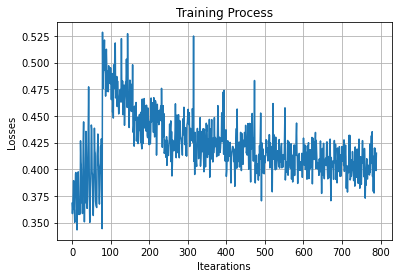

In [69]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

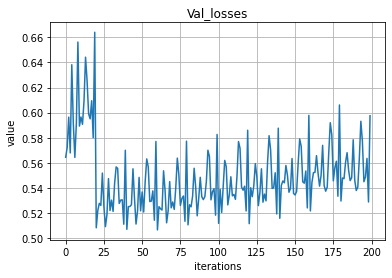

In [70]:
plt.title('Val_losses')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_losses)

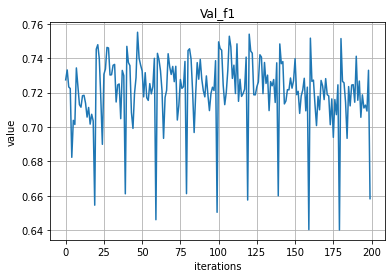

In [71]:
plt.title('Val_f1')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_f1)

Упс, переобучилась

### Улучшение

Бахнем дропаут

In [34]:
class CNN_bet(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embed_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_cat = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) # добавили DropOut
        self.h2out = nn.Linear(in_features=180, out_features=1)
        self.act2 = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feat_bigr = self.dropout(self.act1(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feat_trigr = self.dropout(self.act1(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*
        concat = torch.cat((feat_bigr, feat_trigr), 1)
        bigrams = self.dropout(self.pooling(self.act1(self.bigrams_over_cat(concat))))
        pooling = bigrams.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        proba = self.dropout(self.h2out(pooling))
        proba = self.act2(proba)      
        return proba

In [75]:
set_seed(42)
model = CNN_bet(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [76]:
set_seed(42)
val_dataset = MyDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [77]:
set_seed(42)
losses, val_losses, val_losses_epoch, val_f1s, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, device=DEVICE, metric=f1_score, n_epochs=10)

Training...


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

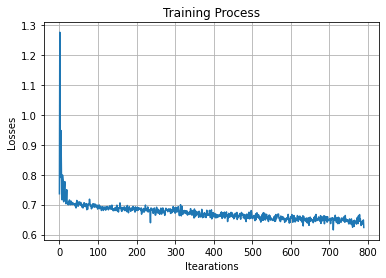

In [78]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

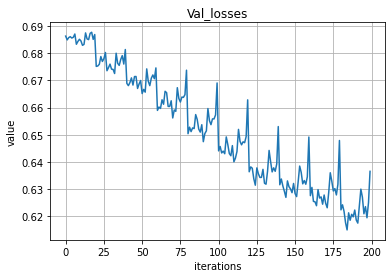

In [81]:
plt.title('Val_losses')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_losses)

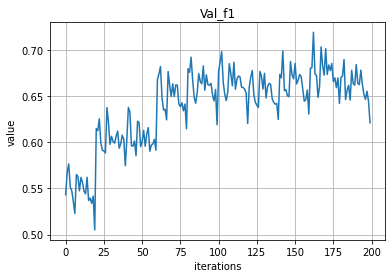

In [82]:
plt.title('Val_f1')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_f1s)

Кажется, стало получше

## Комбинация эмбеддингов и символьных признаков

In [84]:
sym_vocab = Counter()
for line in tqdm(all_df.text):
    sym_vocab.update(list(line))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [87]:
symbol2id = {'PAD':0}

for symbol in sym_vocab:
    symbol2id[symbol] = len(symbol2id)
len(symbol2id)

366

In [88]:
class WordSymDataset(Dataset):
    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] if symbol in symbol2id else symbol2id['UNK'] for symbol in symbols])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch):
      word_ids, symb_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symb_ids = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_symb_ids, y

In [91]:
set_seed(42)
train_dataset = WordSymDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [92]:
set_seed(42)
val_dataset = WordSymDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [93]:
class WordSymCNN(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)

        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.act1 = nn.ReLU()
        self.h2out = nn.Linear(in_features=360, out_features=1)
        self.act2 = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2)
        feat_bigr = self.pooling(self.act1(self.bigrams(embedded_symb)))
        feat_trigr = self.pooling(self.act1(self.trigrams(embedded_symb)))
        
        pooling1 = feat_bigr.max(2)[0] 
        pooling2 = feat_trigr.max(2)[0]

        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        proba = self.h2out(concat) 
        proba = self.act2(proba)      
        return proba

In [95]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [103]:
def train(model, train_l, val_l, optimizer, criterion, device, metric, n_epochs):
    set_seed(42)
    losses = []
    val_losses = []
    val_losses_epoch = []
    val_f1s = []
    val_f1_epoch = []
    print('Training...')
    for n_epoch in range(n_epochs):
        try:
            progress_bar = tqdm(total=len(train_l.dataset), desc='Epoch {}'.format(n_epoch + 1))
            model.train() # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов
            for w, s, y in train_l:
                optimizer.zero_grad() # обнуляем градиенты
                y_pred = model(w, s) # прогоняем данные через модель
                loss = criterion(y_pred, y) # считаем значение функции потерь
                loss.backward()  # считаем градиенты  
                optimizer.step() # обновляем веса 
                losses.append(loss.item()) # сохраняем значение функции потерь
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))
                progress_bar.update(w.shape[0])
            progress_bar.close()
            val_loss, val_metric = evaluate(val_l, model, criterion, metric, device)
            val_losses.extend(val_loss)
            val_f1s.extend(val_metric)
        except KeyboardInterrupt:
            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_f1s, val_f1_epoch

In [104]:
set_seed(42)
losses, val_losses, val_losses_epoch, val_f1s, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, device=DEVICE, metric=f1_score, n_epochs=10)

Training...


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

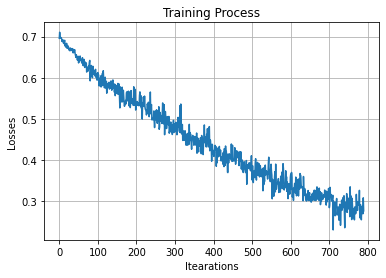

In [105]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

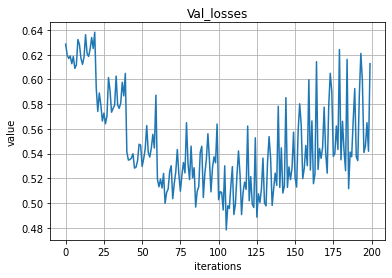

In [106]:
plt.title('Val_losses')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_losses)

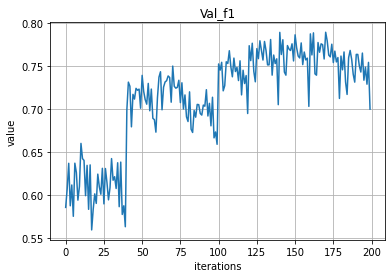

In [107]:
plt.title('Val_f1')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_f1s)

### Улучшение

Добавим дропаут и эпох

In [109]:
class WordSymCNN_bet(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)

        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.act1 = nn.ReLU()
        self.h2out = nn.Linear(in_features=360, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.act2 = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2)
        feat_bigr = self.dropout(self.pooling(self.act1(self.bigrams(embedded_symb))))
        feat_trigr = self.dropout(self.pooling(self.act1(self.trigrams(embedded_symb))))
        
        pooling1 = feat_bigr.max(2)[0] 
        pooling2 = feat_trigr.max(2)[0]

        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        proba = self.h2out(concat) 
        proba = self.act2(proba)      
        return proba

In [110]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymCNN_bet(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [115]:
set_seed(42)
losses, val_losses, val_losses_epoch, val_f1s, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, device=DEVICE, metric=f1_score, n_epochs=30)

Training...


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/80000 [00:00<?, ?it/s]

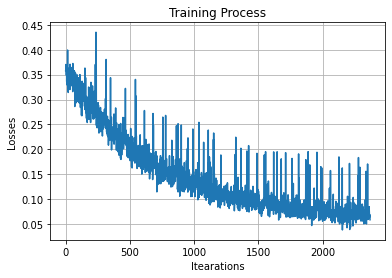

In [116]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

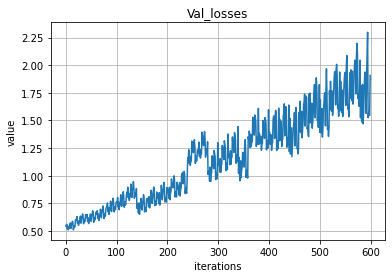

In [117]:
plt.title('Val_losses')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_losses)

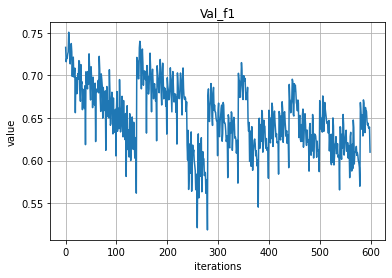

In [118]:
plt.title('Val_f1')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_f1s)

Что-то тут всё плохо

Попробуем покрутить гиперпараметры

In [126]:
class WordSymCNN_bet_2(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=300)

        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=200, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.act1 = nn.ReLU()
        self.h2out = nn.Linear(in_features=600, out_features=1)
        self.dropout = nn.Dropout(p=0.7)
        self.act2 = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2)
        feat_bigr = self.dropout(self.pooling(self.act1(self.bigrams(embedded_symb))))
        feat_trigr = self.dropout(self.pooling(self.act1(self.trigrams(embedded_symb))))
        
        pooling1 = feat_bigr.max(2)[0] 
        pooling2 = feat_trigr.max(2)[0]

        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        proba = self.h2out(concat) 
        proba = self.act2(proba)      
        return proba

In [127]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymCNN_bet_2(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [128]:
set_seed(42)
losses, val_losses, val_losses_epoch, val_f1s, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, device=DEVICE, metric=f1_score, n_epochs=15)

Training...


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/80000 [00:00<?, ?it/s]

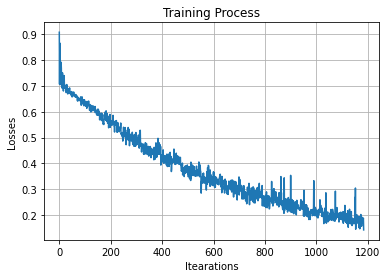

In [129]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

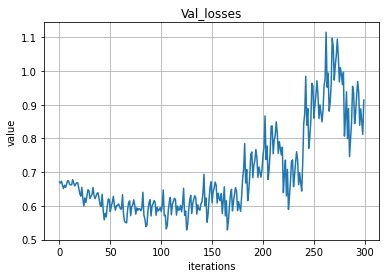

In [130]:
plt.title('Val_losses')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_losses)

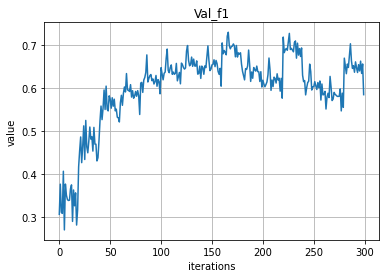

In [131]:
plt.title('Val_f1')
plt.xlabel('iterations')
plt.ylabel('value')
plt.grid()
plt.plot(val_f1s)

Кажется, всё равно переобучаемся, но по крайней мере стало лучше.